In [0]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
#from scipy.misc import imsave
import matplotlib.pyplot as plt
#import scipy.misc as imsave
warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [0]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [0]:
#Hiperparametreler

m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 50

In [0]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

In [0]:
inputs = concat([X, label])

In [0]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [0]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [0]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [0]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [0]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [0]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [0]:
encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          407040      concatenate_1[0][0]        

In [0]:
decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               6656      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total params: 408,848
Trainable params: 408,848
Non-trainable params: 0
_________________________________________________________________


In [0]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [0]:
cvae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          407040      concatenate_1[0][0]        

In [0]:
# compile and fit
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
							validation_data = ([X_test, y_test], X_test),
							callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 164us/step - loss: 201.0008 - KL_loss: 8.6818 - recon_loss: 192.3189 - val_loss: 158.6816 - val_KL_loss: 4.4222 - val_recon_loss: 154.2594
Epoch 2/50
60000/60000 [==============================] - 9s 150us/step - loss: 150.6808 - KL_loss: 4.2629 - recon_loss: 146.4180 - val_loss: 145.3845 - val_KL_loss: 4.2043 - val_recon_loss: 141.1803
Epoch 3/50
60000/60000 [==============================] - 9s 150us/step - loss: 143.5047 - KL_loss: 4.2188 - recon_loss: 139.2860 - val_loss: 141.7711 - val_KL_loss: 4.1956 - val_recon_loss: 137.5755
Epoch 4/50
60000/60000 [==============================] - 9s 149us/step - loss: 140.8130 - KL_loss: 4.2257 - recon_loss: 136.5872 - val_loss: 139.7250 - val_KL_loss: 4.2192 - val_recon_loss: 135.5058
Epoch 5/50
60000/60000 [==============================] - 9s 149us/step - loss: 139.1653 - KL_loss: 4.2475 - recon_loss: 134.9178 - val_loss: 138.326

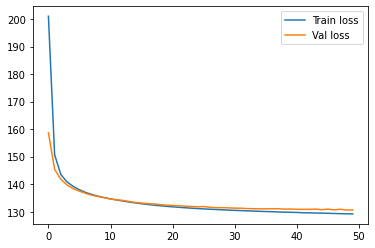

In [0]:
import matplotlib.pyplot as plt
plt.plot(cvae_hist.history["loss"],label="Train loss")
plt.plot(cvae_hist.history["val_loss"],label="Val loss")
plt.legend()# labelların gözükmesini sağlamak
plt.show()

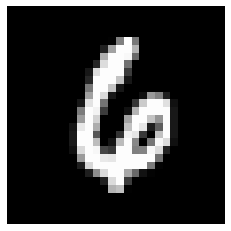

6


In [0]:
plt.imshow(X_train[39].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()
print(Y_train[39])

In [0]:
encoded_X0 = encoder.predict([X_train[0].reshape((1, 784)), y_train[0].reshape((1, 10))])
print(encoded_X0)

[[ 0.2678062  -0.24923882]]


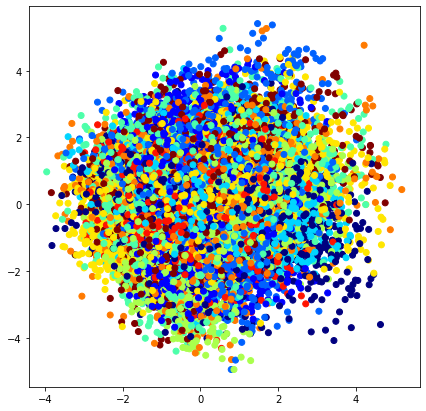

In [0]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

In [0]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(9)
print(sample_3)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


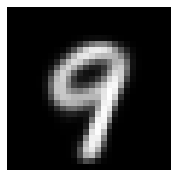

In [0]:
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

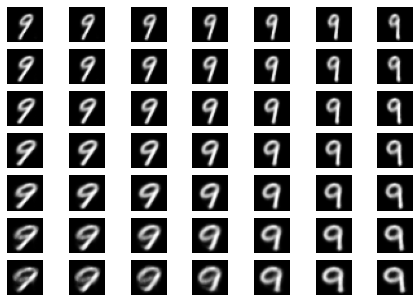

In [0]:
dig = 9
sides = 7
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

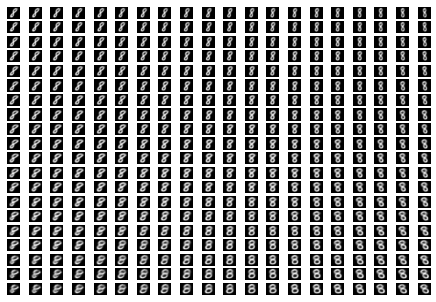

In [0]:
dig = 8
sides = 20
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()